Initial shape: (200000, 9)
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647   

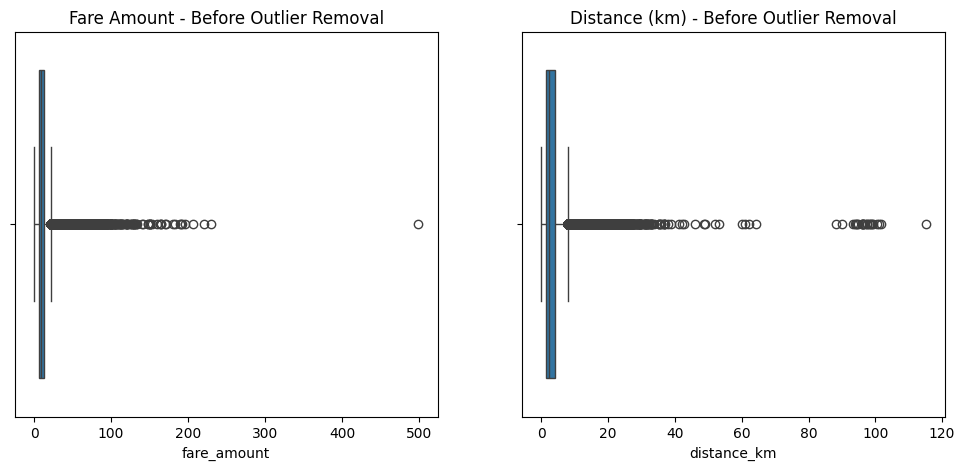

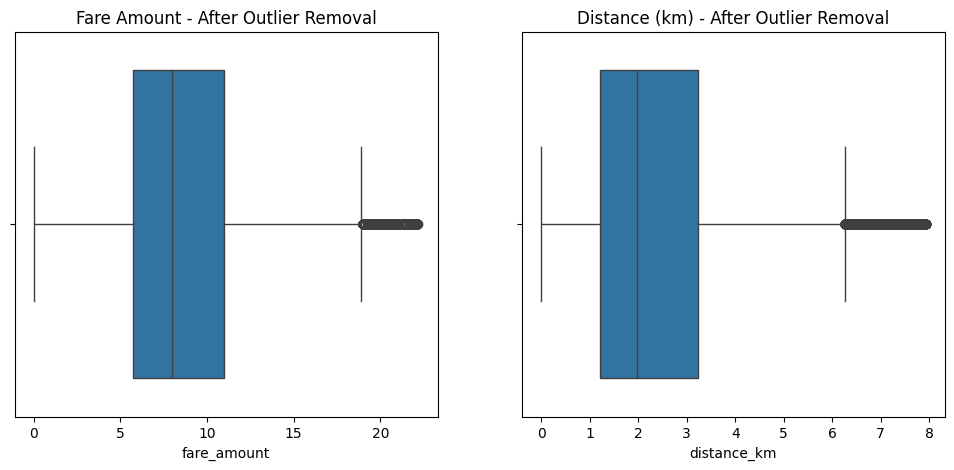

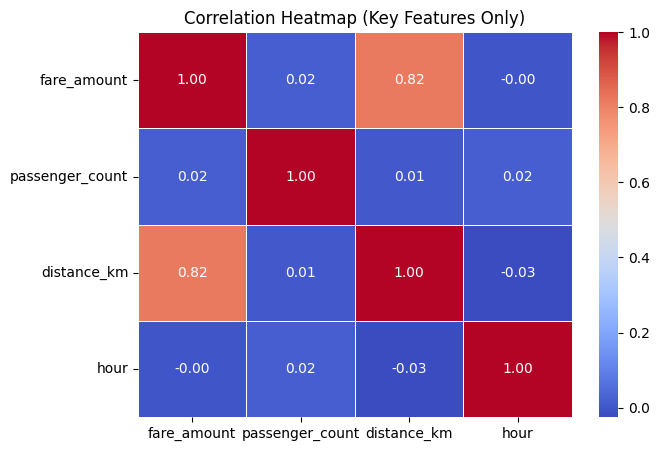


Linear Regression Results:
R2 Score : 0.6701
RMSE     : 2.2891
MAE      : 1.6433

Random Forest Regression Results:
R2 Score : 0.6873
RMSE     : 2.2287
MAE      : 1.5913


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

# --- Step 1: Load and Pre-process the dataset ---
df = pd.read_csv("uber.csv")  # ensure the file is in the same folder
print("Initial shape:", df.shape)
print(df.head())

# Drop missing values
df.dropna(inplace=True)

# Convert pickup_datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.dropna(subset=['pickup_datetime'], inplace=True)

# Filter unrealistic values and drop non-numeric columns
df = df[df['fare_amount'] > 0]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]
df = df[
    (df['pickup_latitude'].between(40, 42)) &
    (df['pickup_longitude'].between(-75, -72)) &
    (df['dropoff_latitude'].between(40, 42)) &
    (df['dropoff_longitude'].between(-75, -72))
]
# Drop non-numeric and unnecessary columns (Added for clarity, similar to Code 1)
df.drop(['Unnamed: 0', 'key'], axis=1, inplace=True, errors='ignore')


# Feature: Extract hour of the day from datetime
df['hour'] = df['pickup_datetime'].dt.hour

# Calculate distance using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a))  # distance in km

df['distance_km'] = haversine(
    df['pickup_longitude'], df['pickup_latitude'],
    df['dropoff_longitude'], df['dropoff_latitude']
)

# Remove 0-distance rows
df = df[df['distance_km'] > 0]
print("Shape after preprocessing:", df.shape)

# --- Step 2: Identify Outliers using IQR (with Before/After Visualization) ---

# Visualize BEFORE outlier removal
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['fare_amount'])
plt.title("Fare Amount - Before Outlier Removal")
plt.subplot(1, 2, 2)
sns.boxplot(x=df['distance_km'])
plt.title("Distance (km) - Before Outlier Removal")
plt.show()

# IQR function
def iqr_filter(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5*IQR, Q3 + 1.5*IQR

fare_min, fare_max = iqr_filter('fare_amount')
dist_min, dist_max = iqr_filter('distance_km')

# Apply the filter
df = df[(df['fare_amount'].between(fare_min, fare_max)) &
        (df['distance_km'].between(dist_min, dist_max))]

# Visualize AFTER outlier removal
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['fare_amount'])
plt.title("Fare Amount - After Outlier Removal")
plt.subplot(1, 2, 2)
sns.boxplot(x=df['distance_km'])
plt.title("Distance (km) - After Outlier Removal")
plt.show()

# --- Step 3: Check Correlation ---
corr_features = ['fare_amount', 'passenger_count', 'distance_km', 'hour']
plt.figure(figsize=(7,5))
sns.heatmap(df[corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Key Features Only)")
plt.show()

# --- Step 4: Model Building (Linear & Random Forest Regression) ---
features = ['passenger_count', 'distance_km', 'hour']
X = df[features]
y = df['fare_amount']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression Model ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# --- Random Forest Regression Model (Increased complexity for better results) ---
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- Step 5: Evaluate and Compare Models ---
def evaluate(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"R2 Score : {r2:.4f}")
    print(f"RMSE     : {rmse:.4f}")
    print(f"MAE      : {mae:.4f}")

evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Random Forest Regression", y_test, y_pred_rf)